# Ball and Racket

*(Sotiropoulos et al. 2012)* proposes to use a Ball and $N$ Bingham distributions of Sticks to describe axon dispersion in tissues with $N\geq1$ axon bundle populations. A Bingham distribution $B(\kappa_1,\kappa_2,\boldsymbol{\mu})$, oriented along orientation $\boldsymbol{\mu}\in\mathbb{S}^2$, quantifies the dispersion of Sticks around $\boldsymbol{\mu}$.
When $\kappa_1\neq\kappa_2$ the Bingham model describes "fanning" or "bending" axon populations *(Kaden et al. 2007)*.
The existence of such configurations has been confirmed with histology in the cortex *(Kleinnijenhuis et al. 2013)* and corpus callosum *(Budde and Annese 2013)*.
Aptly, this model is called Ball and Rackets (BAR). The "Racket" presumably comes from the fanning of strings on a tennis racket. Bar describes the diffusion signal as

\begin{align}
 E^{\textrm{Ball and}}_{\textrm{Rackets}}= \underbrace{f_{\textrm{iso}}\overbrace{E_{\textrm{iso}}(\lambda_{\textrm{iso}})}^{\textrm{Ball}}}_{\textrm{Extra-Axonal}} +\sum_{i=1}^N\underbrace{f_r^i\overbrace{B(\kappa_1,\kappa_2,\boldsymbol{\mu})}^{\textrm{Bingham}}\,*_{\mathbb{S}^2}\,\overbrace{E_r(\cdot|\lambda_\parallel)}^{\textrm{Stick}}}_{\textrm{Intra-Axonal}}
\end{align}

where $*_{\mathbb{S}^2}$ denotes the spherical convolution of the Bingham distribution with the convolution kernel, i.e. the Stick. As such, BAR was the first model designed to estimate axon dispersion and fanning separately per axon bundle. However, as extra-axonal diffusion in between axons is hindered and anisotropic *(Assaf et al. 2004)*, lumping it all together in one isotropic compartment will likely bias estimated model parameters. Moreover, they found that estimating dispersion in crossing tissue configurations in the presence of noise is highly unstable, effectly limiting its application to voxels with one axon bundle when $N=1$. 

## Generate Ball and Racket model
The Ball and Racket model can be generated by first calling the basic Ball and Stick components:

In [1]:
from dmipy.signal_models import gaussian_models, cylinder_models
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()

Creating a Bingham-Dispersed Stick representation can then be done as follows:

In [2]:
from dmipy.distributions.distribute_models import SD2BinghamDistributed
dispersed_stick = SD2BinghamDistributed([stick])

The Ball and Racket model then finally combined using the MultiCompartmentModel instance:

In [3]:
from dmipy.core.modeling_framework import MultiCompartmentModel
BAR_mod = MultiCompartmentModel(models=[dispersed_stick, ball])
BAR_mod.parameter_names

['SD2BinghamDistributed_1_SD2Bingham_1_beta_fraction',
 'SD2BinghamDistributed_1_SD2Bingham_1_odi',
 'G1Ball_1_lambda_iso',
 'SD2BinghamDistributed_1_SD2Bingham_1_mu',
 'SD2BinghamDistributed_1_SD2Bingham_1_psi',
 'SD2BinghamDistributed_1_C1Stick_1_lambda_par',
 'partial_volume_0',
 'partial_volume_1']

As you can see, the BAR model has many parameters. To simplify the fitting process, it is possible to fix the diffusivity as we did before with the Ball and Stick model. But, keep in mind that fixing parameters can introduce biases into estimated parameters.

In [4]:
BAR_mod.set_fixed_parameter("SD2BinghamDistributed_1_C1Stick_1_lambda_par", 1.7e-9)

In [5]:
# notice that lambda_par is now no longer an estimated parameter.
BAR_mod.parameter_names

['SD2BinghamDistributed_1_SD2Bingham_1_beta_fraction',
 'SD2BinghamDistributed_1_SD2Bingham_1_odi',
 'G1Ball_1_lambda_iso',
 'SD2BinghamDistributed_1_SD2Bingham_1_mu',
 'SD2BinghamDistributed_1_SD2Bingham_1_psi',
 'partial_volume_0',
 'partial_volume_1']

# Human Connectome Project Example

In [5]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


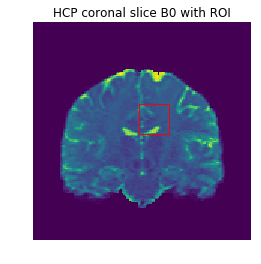

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

## Fit Ball and Racket to HCP data
Having numba and pathos installed, fitting the model to a coronal slice takes about 40 minutes:

In [7]:
BAR_fit_hcp = BAR_mod.fit(scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 42.4190790653 seconds
Fitting of 8181 voxels complete in 2292.53698182 seconds.
Average of 0.280226987144 seconds per voxel.


## Visualize results

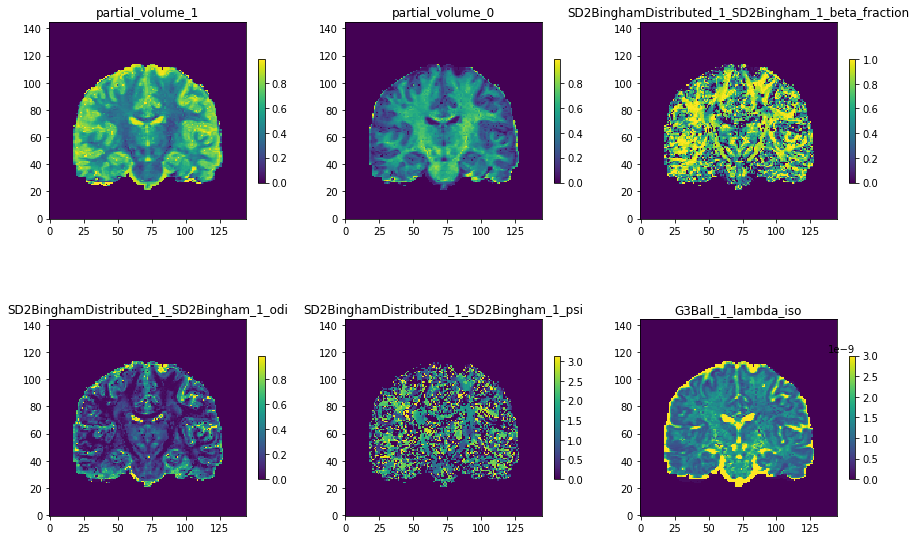

In [8]:
fitted_parameters = BAR_fit_hcp.fitted_parameters

fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1

Notice that we get some familiar maps, where the Ball model takes the role of extra-axonal and CSF compartments, and the stick takes the intra-axonal compartment.

The more unfamiliar maps are those of $\beta$, $\kappa$ and $\psi$. $\kappa$ represents primary isotropic concentration as in NODDI, while $\beta$ describes the anisotropy of the concentration (bending or fanning tissue). $\psi$ describes the angle of the anisotropy.

Also notice that the maps are not completely smooth (especially lambda_par) as optimization can still fall in a local minima despite the brute force optimization. 

## Estimating Fiber Orientation Distributions (FODs)

We estimate FODs on the right side of the corpus callosum and use the estimated concentration $\kappa$ as background.

In [9]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
sphere = get_sphere(name='symmetric724')
fods = BAR_fit_hcp.fod(sphere.vertices)

In [10]:
import numpy as np
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

odi_res = fitted_parameters['SD2BinghamDistributed_1_SD2Bingham_1_odi']
odi_im = slicer(odi_res[70:90,0, 70:90],interpolation='nearest', affine=affine, opacity=0.7)

beta_res = fitted_parameters['SD2BinghamDistributed_1_SD2Bingham_1_beta_fraction']
beta_im = slicer(beta_res[70:90,0, 70:90],interpolation='nearest', affine=affine, opacity=0.7)

In [11]:
from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods[70:90,:, 70:90], sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, odi_im)
fvtk.record(ren=ren, size=[700, 700], out_path='dipy_odi.png')

ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods[70:90,:, 70:90], sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, beta_im)
fvtk.record(ren=ren, size=[700, 700], out_path='dipy_beta.png')

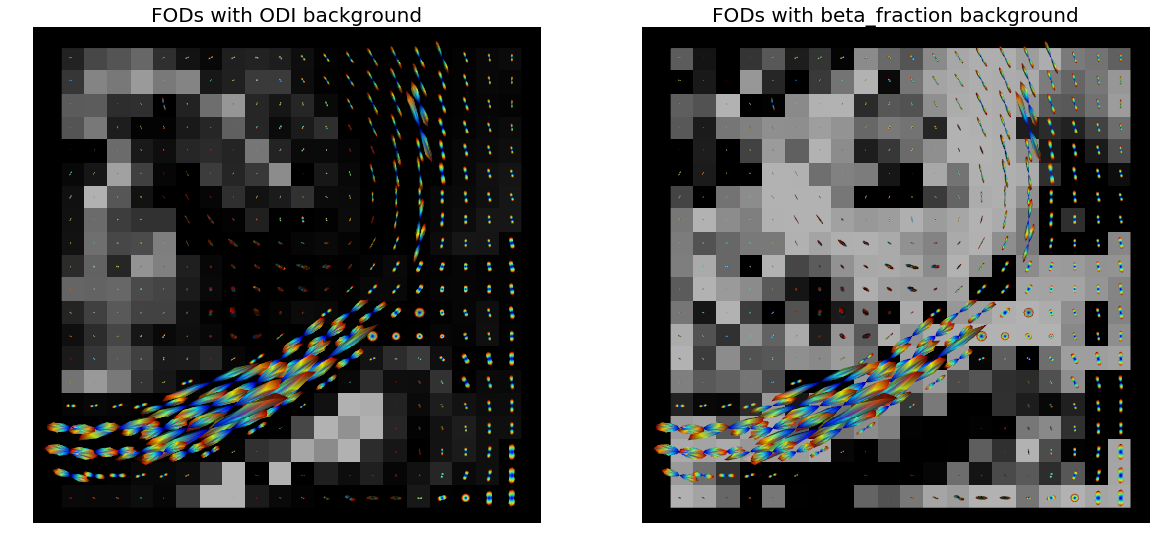

In [12]:
import matplotlib.image as mpimg
img1 = mpimg.imread('dipy_odi.png')
img2 = mpimg.imread('dipy_beta.png')

fig, axs = plt.subplots(1, 2, figsize=[20, 70])
axs[0].set_title('FODs with ODI background', fontsize=20)
axs[0].imshow(img1[100:-97, 100:-85])
axs[0].axis('off')
axs[1].set_title('FODs with beta_fraction background', fontsize=20)
axs[1].imshow(img2[100:-97, 100:-85])
axs[1].axis('off');

You can see the corpus callosum coming in the from the left and joining the centrum semiovale on the right. The intensity of the background shows the ODI of the Bingham distribution on the left, and beta_fraction on the right. Notice it is high in the corpus callosum and lower in non-white matter areas. Also notice that in the CSF on the bottom you see very high $\kappa$, but it means nothing since the intra-axonal volume fraction close to zero in these areas. Also notice that Ball and Racket cannot estimate crossings, which are expected in the centrum semiovale on the right. Using multiple compartments to model crossings is explored in the Microstructure in Crossings examples.

In [13]:
from os import remove
remove('dipy_odi.png')
remove('dipy_beta.png')

## Estimating Error Metrics: MSE and $R^2$

Whenever you fit a model, it's always wise to check out the error of the model fit. Here we estimate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination. In MSE the lower is better, while $R^2$ has an upper bound of one, which represents a perfect model fit.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/fitted_modeling_framework.py:124: RuntimeWarning: invalid value encountered in divide
  data_ = data / self.S0[..., None]
/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/fitted_modeling_framework.py:104: RuntimeWarning: invalid value encountered in divide
  data_ = data / self.S0[..., None]


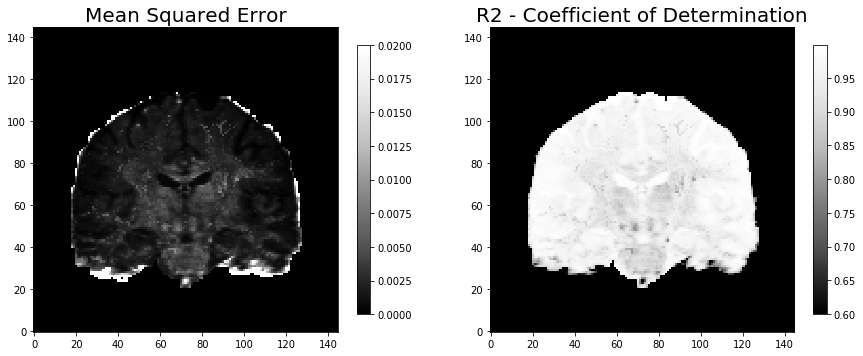

In [14]:
mse = BAR_fit_hcp.mean_squared_error(data_hcp)
R2 = BAR_fit_hcp.R2_coefficient_of_determination(data_hcp)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=0.02, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=0.6, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20);

Ideally, you want the MSE and $R^2$ to show no structure of the underlying data - which would mean the model can at least fit the data equally well everywhere. Instead, in Ball and Racket we can see clearly see the structure of the different brain areas. This means that Ball and Racket model cannot fit the diffusion equally well in all brian areas, and that interpretation of model parameters will be biased when comparing them between these different areas.

When doing these studies, ALWAYS verify whether differences in estimated parameters reflect actual tissue changes, or only reflect the limitations of the model itself.

## References
- Assaf, Yaniv, et al. "New modeling and experimental framework to characterize hindered and restricted water diffusion in brain white matter." Magnetic Resonance in Medicine 52.5 (2004): 965-978.
- Sotiropoulos, Stamatios N., Timothy EJ Behrens, and Saad Jbabdi. "Ball and rackets: inferring fiber fanning from diffusion-weighted MRI." Neuroimage 60.2 (2012): 1412-1425.
- Kaden, Enrico, Thomas R. Knösche, and Alfred Anwander. "Parametric spherical deconvolution: inferring anatomical connectivity using diffusion MR imaging." NeuroImage 37.2 (2007): 474-488.
- Budde, Matthew D., and Jacopo Annese. "Quantification of anisotropy and fiber orientation in human brain histological sections." Frontiers in integrative neuroscience 7 (2013): 3.
- Kleinnijenhuis, M., et al. "Detailed laminar characteristics of the human neocortex revealed by NODDI and histology." 2013.